In [2]:
import networkx as nx
import geopandas as gp
import pandas as pd 
import numpy as np
from glob import glob
from shapely.geometry import Point
import matplotlib.pyplot as plt
import json
import folium

import sklearn
from sklearn.cluster import spectral_clustering

from scipy.cluster import hierarchy
from scipy.spatial import distance

%matplotlib inline


Bad key "axes.prop_cycle" on line 11 in
/Users/michelleho/anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/stylelib/seaborn.mplstyle.
You probably need to get an updated matplotlibrc file from
http://matplotlib.sf.net/_static/matplotlibrc or from the matplotlib source
distribution


# Download and parse data for networkx

In [6]:
! curl -O https://s3.amazonaws.com/tripdata/201307-201402-citibike-tripdata.zip
! unzip 201307-201402-citibike-tripdata.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  170M  100  170M    0     0  6194k      0  0:00:28  0:00:28 --:--:-- 5824k
Archive:  201307-201402-citibike-tripdata.zip
  inflating: 2014-02 - Citi Bike trip data.csv  
  inflating: 2014-01 - Citi Bike trip data.csv  
  inflating: 2013-12 - Citi Bike trip data.csv  
  inflating: 2013-11 - Citi Bike trip data.csv  
  inflating: 2013-10 - Citi Bike trip data.csv  
  inflating: 2013-09 - Citi Bike trip data.csv  
  inflating: 2013-08 - Citi Bike trip data.csv  
  inflating: 2013-07 - Citi Bike trip data.csv  


In [107]:
list(data.columns)

['tripduration',
 'starttime',
 'stoptime',
 'start station id',
 'start station name',
 'start station latitude',
 'start station longitude',
 'end station id',
 'end station name',
 'end station latitude',
 'end station longitude',
 'bikeid',
 'usertype',
 'birth year',
 'gender']

In [3]:
data= pd.concat([pd.read_csv(f) for f in glob("* trip data.csv")])

od =(data.groupby(['start station id', 'end station id'])
         .count()
         .rename(columns={'tripduration' : 'weight'})
         .assign(inv_weight= lambda x: 1.0/x['weight'] )
         .reset_index()[['start station id', 'end station id','weight','inv_weight']])

network = nx.from_pandas_dataframe(od,
                                   source= 'start station id',
                                   target='end station id',
                                   edge_attr='inv_weight',
                                   create_using=nx.DiGraph())
data.groupby('bikeid').count().sort_values(by='gender',ascending=False).head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,usertype,birth year,gender
bikeid,,,,,,,,,,,,,,
17279,1341,1341,1341,1341,1341,1341,1341,1341,1341,1341,1341,1341,1341,1341
16049,1331,1331,1331,1331,1331,1331,1331,1331,1331,1331,1331,1331,1331,1331
18165,1324,1324,1324,1324,1324,1324,1324,1324,1324,1324,1324,1324,1324,1324
16399,1313,1313,1313,1313,1313,1313,1313,1313,1313,1313,1313,1313,1313,1313
15013,1305,1305,1305,1305,1305,1305,1305,1305,1305,1305,1305,1305,1305,1305


# Isolate most active bike

In [8]:
busybike = data[data['bikeid']==17279]
busybike.sort_values(by='starttime').head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
223259,528,2013-07-11 08:16:05,2013-07-11 08:24:53,469,Broadway & W 53 St,40.763441,-73.982681,529,W 42 St & 8 Ave,40.757570,-73.990985,17279,Subscriber,1977,1
223602,983,2013-07-11 08:25:19,2013-07-11 08:41:42,529,W 42 St & 8 Ave,40.757570,-73.990985,440,E 45 St & 3 Ave,40.752554,-73.972826,17279,Subscriber,1976,1
234904,887,2013-07-11 17:17:42,2013-07-11 17:32:29,440,E 45 St & 3 Ave,40.752554,-73.972826,497,E 17 St & Broadway,40.737050,-73.990093,17279,Subscriber,1975,2
237818,622,2013-07-11 18:33:19,2013-07-11 18:43:41,466,W 25 St & 6 Ave,40.743954,-73.991449,528,2 Ave & E 31 St,40.742909,-73.977061,17279,Subscriber,1974,1
238245,1061,2013-07-11 18:48:19,2013-07-11 19:06:00,528,2 Ave & E 31 St,40.742909,-73.977061,281,Grand Army Plaza & Central Park S,40.764397,-73.973715,17279,Subscriber,1983,2


# Find jumps (or rebalancing routes) for most active bike

In [9]:
busybikenext = (busybike.sort_values(by='starttime')
                        .assign(nextstationid = busybike.sort_values(by='starttime')['start station id'].shift(-1).fillna(0).astype('int'))
                )

jumps = busybikenext[~(busybikenext['end station id'] == busybikenext['nextstationid'])]

jump_count =(jumps.groupby(['end station id', 'nextstationid'])
         .count()
         .rename(columns={'tripduration' : 'weight'})
         .assign(inv_weight= lambda x: 1.0/x['weight'] )
         .reset_index()[['end station id',
                         'nextstationid',
                         'weight',
                         'inv_weight']])

jumpnetwork = nx.from_pandas_dataframe(jump_count.query('nextstationid != 0'),
                                       source= 'end station id',
                                       target='nextstationid',
                                       edge_attr='inv_weight',
                                       create_using=nx.DiGraph())

# Find all station node positions

In [5]:
stations = (data[['start station id', 'start station latitude', 'start station longitude','start station name',]]
            .drop_duplicates('start station id')
            .rename(columns={'start station latitude':'latitude', 'start station longitude':'longitude'})
            .set_index('start station id'))
station_positions={}
for c in stations.index:
    station_positions[c]=(stations['longitude'][c],stations['latitude'][c])

# Plotting busybike jump network with networkx

/Users/michelleho/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/michelleho/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


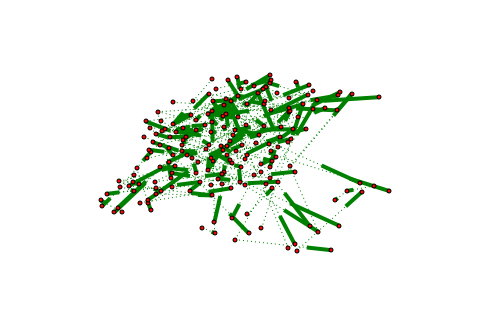

In [11]:
nx.draw(jumpnetwork,pos=station_positions,with_labels=False,node_size=15,style='dotted',edge_color='green',arrows=True)

# Plot rebalancing (jump) network for all bikes

In [ ]:
# This cell takes a while to run... warning!
all_jumps = pd.DataFrame()
for i in data['bikeid'].unique():
    bike = data[data['bikeid']==i] 
    nextbike = (bike.sort_values(by='starttime')
                        .assign(nextstationid = bike.sort_values(by='starttime')['start station id'].shift(-1).fillna(0).astype('int'))
                )
    jumps = nextbike[~(nextbike['end station id'] == nextbike['nextstationid'])]
    jumps.head()
    all_jumps = all_jumps.append(jumps)

In [129]:
all_jump_count =(all_jumps.query('nextstationid != 0').groupby(['end station id', 'nextstationid'])
         .count()
         .rename(columns={'tripduration' : 'weight'})
         .assign(inv_weight= lambda x: 1.0/x['weight'] )
         .reset_index()[['end station id',
                         'nextstationid',
                         'weight',
                         'inv_weight']])

In [133]:
# Find most frequent jump routes
all_jump_count.sort_values(by='weight',ascending=False).head()

,end station id,nextstationid,weight,inv_weight
58143,477,465,2811,0.000356
70985,529,2021,1445,0.000692
68925,521,490,1324,0.000755
69660,524,477,639,0.001565
62019,493,529,639,0.001565


In [ ]:
# Use networkx to analyze total jump network and top-10 jump routes

alljumpnetwork = nx.from_pandas_dataframe(all_jump_count,
                                       source= 'end station id',
                                       target='nextstationid',
                                       edge_attr='inv_weight',
                                       create_using=nx.DiGraph())
topjumpnetwork = nx.from_pandas_dataframe(all_jump_count.sort_values(by='weight',ascending=False).head(10),
                                       source= 'end station id',
                                       target='nextstationid',
                                       edge_attr='inv_weight',
                                       create_using=nx.DiGraph())

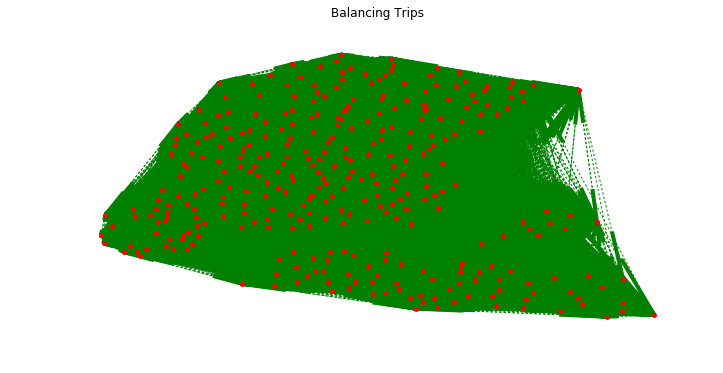

In [146]:
# We're plotting a lot of jump routes here -- may take a minute or two
plt.pyplot.figure(figsize = (12,6))
plt.pyplot.title('All Balancing Trips')
nx.draw(alljumpnetwork,pos=station_positions,with_labels=False,node_size=15,style='dotted',edge_color='green',arrows=True)

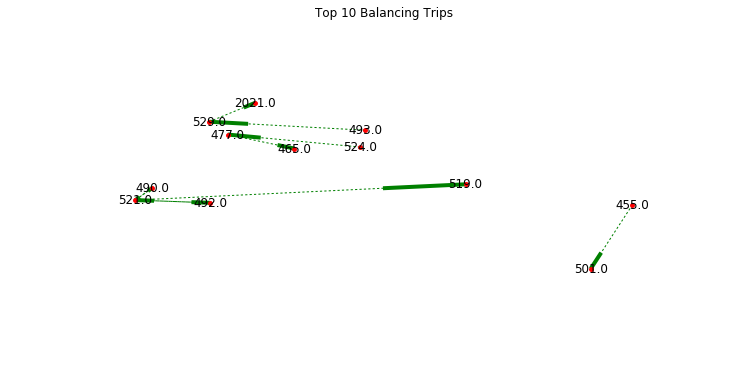

In [149]:
plt.pyplot.title('Top 10 Balancing Trips')
nx.draw(topjumpnetwork,pos=station_positions,with_labels=True,node_size=15,style='dotted',edge_color='green',arrows=True)

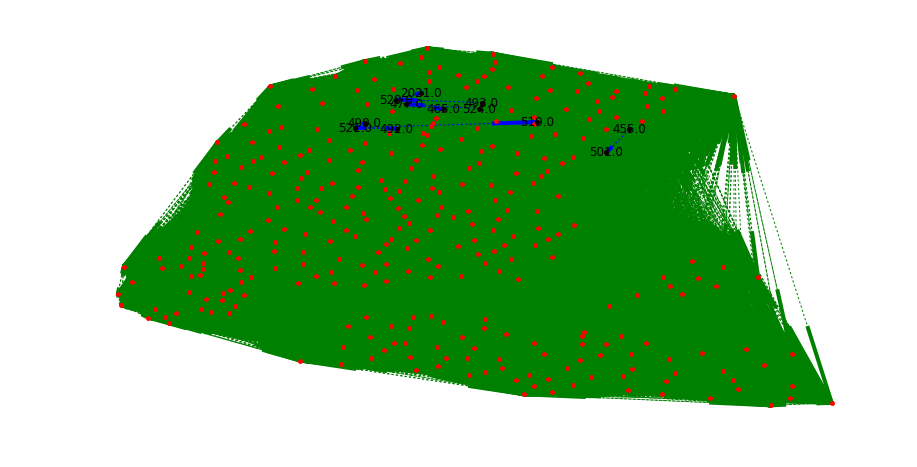

In [151]:
nx.draw(network,pos=station_positions,with_labels=False,node_size=15,style='dotted',edge_color='green',arrows=True)
nx.draw(topjumpnetwork,pos=station_positions,with_labels=True,node_size=15,style='dotted',node_color='black',edge_color='blue',arrows=True)

In [ ]:
# visualize with folium
map_bike = folium.Map(location=[40.730020, -73.969053],tiles='cartodbpositron', zoom_start=13)

for i in stations.iterrows():
    folium.CircleMarker(location=[i[1][0],i[1][1]],radius=1,fill_opacity=1).add_to(map_bike)

map_bike

# Centrality Measures

In [414]:
degree_cent = nx.centrality.degree_centrality(network)
between_cent = nx.centrality.betweenness_centrality(network, weight='inv_weight')

In [415]:
closeness_cent = nx.centrality.closeness_centrality(network,distance='inv_weight')

In [158]:
# This is “left” eigenvector centrality which corresponds to the in-edges
eigen_cent = nx.centrality.eigenvector_centrality(network,weight='inv_weight')
eigen_cent_numpy = nx.centrality.eigenvector_centrality_numpy(network,weight='inv_weight')

In [390]:
# This is “right” eigenvector centrality which corresponds to the out-edges
eigen_cent_out = nx.centrality.eigenvector_centrality(network.reverse(),weight='inv_weight')
eigen_cent_numpy_out = nx.centrality.eigenvector_centrality_numpy(network.reverse(),weight='inv_weight')

In [416]:
centralities = {'degree_centrality':degree_cent,
                'betweeness_centrality':between_cent,
                'closeness_centrality':closeness_cent,
                'eigenvector_centrality':eigen_cent,
                'eigenvector_out_centrality':eigen_cent_out}

In [417]:
for key, values in centralities.iteritems():
    stations['{}'.format(key)] = stations['start station id'].map(values)

In [418]:
stations.to_csv('centralities_citibike.csv')

In [485]:
# eight bins diverging and qualitative color palette
diverge_colors = ["#d53e4f",
                    "#f46d43",
                    "#fdae61",
                    "#fee08b",
                    "#e6f598",
                    "#abdda4",
                    "#66c2a5",
                    "#3288bd"]

qualitative_colors=['#7fc97f',
                    '#beaed4',
                    '#fdc086',
                    '#ffff99',
                    '#386cb0',
                    '#f0027f',
                    '#bf5b17',
                    '#666666',]

In [327]:
values = degree_cent.values()
bins = np.linspace(min(degree_cent.values()),max(degree_cent.values()), num=8)
binassign = np.digitize(values, bins)
binassign = binassign - 1

In [368]:
for num, centralities in enumerate([degree_cent,between_cent,closeness_cent,eigen_cent]):
    values = centralities.values()
    bins = np.linspace(min(centralities.values()),max(centralities.values()), num=8)
    binassign = np.digitize(values, bins)
    binassign = binassign - 1
    bin_dict = dict(zip(centralities.keys(), binassign))
    map_bike = folium.Map(location=[40.730020, -73.969053],
                          tiles='cartodbdark_matter',
                          zoom_start=12,
                         )

    for i in stations.iterrows():
        station_id = i[0]
        folium.CircleMarker(location=[i[1][0],i[1][1]],
                            radius=1,fill_opacity=1,
                            color=diverge_colors[bin_dict[station_id]],
                            fill_color=diverge_colors[bin_dict[station_id]]).add_to(map_bike)
    map_bike.save('centralitymap_{}.html'.format(num))

# Graph Partitioning explorations

## Spectral clustering

/Users/michelleho/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


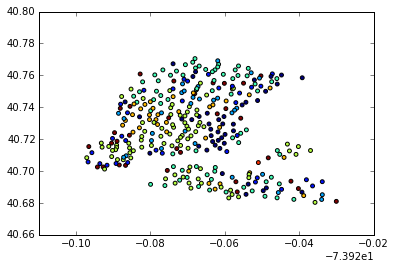

In [6]:
laplacian_matrix = nx.directed_laplacian_matrix(network)
spectral8 = sklearn.cluster.SpectralClustering()
labels = spectral8.fit_predict(laplacian_matrix)
nx.draw_networkx_nodes(network,pos=station_positions,node_color=labels,with_labels=False,node_size=15)

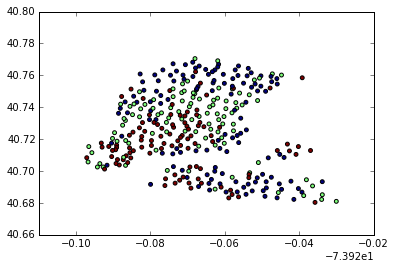

In [7]:
# three clusters
spectral = sklearn.cluster.SpectralClustering(n_clusters=3)
labels = spectral.fit_predict(laplacian_matrix)
nx.draw_networkx_nodes(network,pos=station_positions,node_color=labels,with_labels=False,node_size=15)

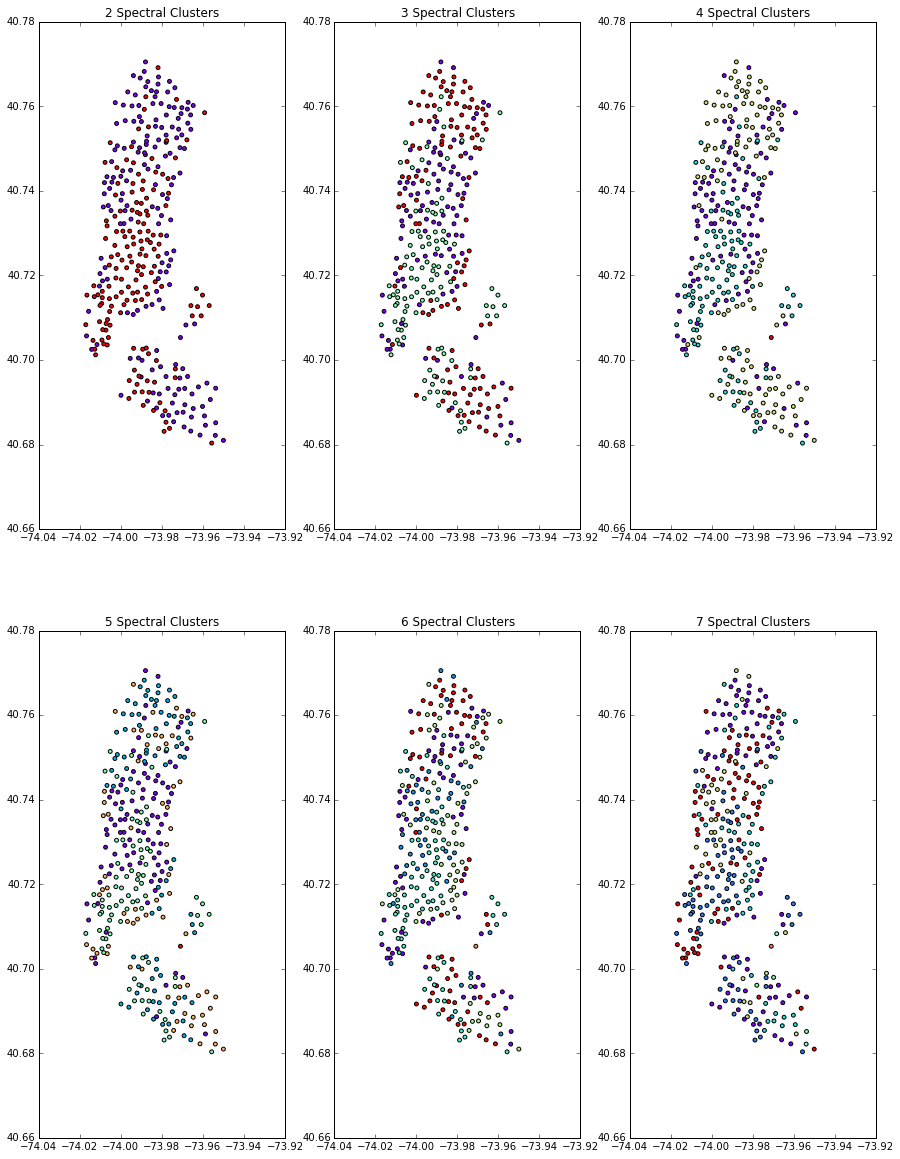

In [11]:
# clusters of sizes 2 to 8
fig, axes = plt.subplots(ncols=3,nrows=2, figsize = (15,20))
for ax, i in zip(axes.flatten(), range(2,8)):
    spectral = sklearn.cluster.SpectralClustering(n_clusters=i)
    labels = spectral.fit_predict(laplacian_matrix)
    nx.draw_networkx_nodes(network,pos=station_positions,node_color=labels,cmap='rainbow',with_labels=False,node_size=15, ax=ax)
    ax.set_title('{} Spectral Clusters'.format(i))

In [10]:
three_spectral_clusters = dict(zip(network.nodes(),labels))

In [ ]:
map_bike = folium.Map(location=[40.730020, -73.969053],
                      tiles='cartodbpositron',
                      zoom_start=12,
                     )
for value in stations.iterrows():
    bikeid = value[0]
    folium.RegularPolygonMarker(location=[value[1][0],value[1][1]],
                        fill_opacity=0.1, 
                        radius=2,
                        color=qualitative_colors[three_spectral_clusters[bikeid]],
                        fill_color=qualitative_colors[three_spectral_clusters[bikeid]],
                        popup='{}, cluster {}'.format(value[1][2],three_spectral_clusters[bikeid])).add_to(map_bike)
map_bike

# Hierarchical Clustering

In [12]:
def create_hc(G):
    """Creates hierarchical cluster of graph G from distance matrix"""
    path_length=nx.all_pairs_shortest_path_length(G)
    distances=np.zeros((len(G),len(G)))
    for u,p in path_length.items():
        for v,d in p.items():
            distances[u][v]=d
    # Create hierarchical cluster
    Y=distance.squareform(distances)
    Z=hierarchy.complete(Y)  # Creates HC using farthest point linkage
    S = hierarchy.single(Y)  # Creates HC using single linkage
    # This partition selection is arbitrary, for illustrive purposes
    membership=list(hierarchy.fcluster(Z,t=1.15))
    # Create collection of lists for blocktmodel
    partition=defaultdict(list)
    for n,p in zip(list(range(len(G))),membership):
        partition[p].append(n)
#    return list(partition.values())

/Users/michelleho/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


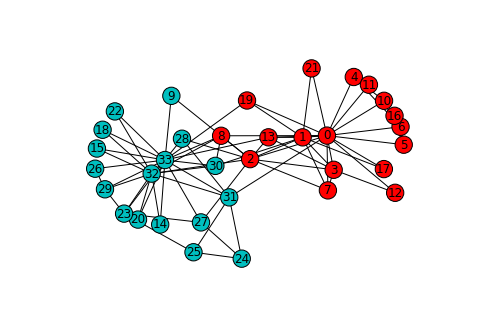

In [13]:
# Karate club example

G=nx.karate_club_graph()
pos = nx.spring_layout(G)

colors = {}
for key, value in G.node.iteritems():
    if value['club'] == 'Mr. Hi':
        colors[key] = 'r'
    else:
        colors[key] = 'c'
nx.draw(G,pos=pos,node_color=colors.values(),with_labels=True)

path_length=nx.all_pairs_shortest_path_length(G)
distances=np.zeros((len(G),len(G)))
for u,p in path_length.items():
    for v,d in p.items():
        distances[u][v]=d
# Create hierarchical cluster
Y = distance.pdist(distances)
Z = hierarchy.complete(Y)  # Creates HC using farthest point linkage
S = hierarchy.single(Y)  # Creates HC using single linkage

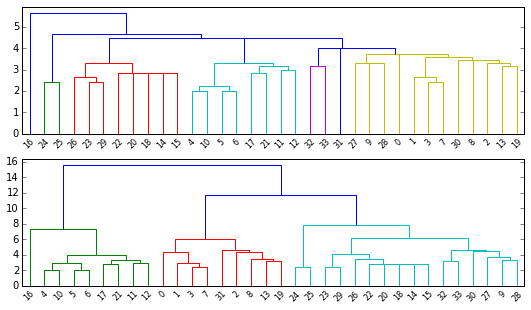

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(9, 5))
dn = hierarchy.dendrogram(S, ax=axes[0],)
dn1 = hierarchy.dendrogram(Z, ax=axes[1])

In [14]:
cutree = hierarchy.cut_tree(S)

In [15]:
hier_labels = {}
colors = ['r','b','g','y']
for i, val in enumerate(cutree.T[30]):
    hier_labels[i] = colors[val]
nx.set_node_attributes(G,'cut_hierachical',hier_labels)

In [16]:
laplacian_karate = nx.laplacian_matrix(G)
w, v = np.linalg.eig(laplacian_karate.toarray())

w_sorted = np.sort(w)
eig_index = list(w).index(w_sorted[1])
w_sorted[1]
second_eigen = v[:,eig_index]

spectral_labels = {}
for i,val in enumerate(second_eigen):
    if val < 0:
        spectral_labels[i] = 'y'
    else:
        spectral_labels[i] = 'g'
nx.set_node_attributes(G,'spectral_bi',spectral_labels)

{0: <matplotlib.text.Text at 0x12ff73450>,
 1: <matplotlib.text.Text at 0x12c790990>,
 2: <matplotlib.text.Text at 0x12c790150>,
 3: <matplotlib.text.Text at 0x12c7901d0>,
 4: <matplotlib.text.Text at 0x12f74fc50>,
 5: <matplotlib.text.Text at 0x12f74f690>,
 6: <matplotlib.text.Text at 0x12f74fa50>,
 7: <matplotlib.text.Text at 0x12f74ffd0>,
 8: <matplotlib.text.Text at 0x12c797390>,
 9: <matplotlib.text.Text at 0x12c7977d0>,
 10: <matplotlib.text.Text at 0x12c797d90>,
 11: <matplotlib.text.Text at 0x12c786ed0>,
 12: <matplotlib.text.Text at 0x12c786ad0>,
 13: <matplotlib.text.Text at 0x12c786490>,
 14: <matplotlib.text.Text at 0x12c77ae50>,
 15: <matplotlib.text.Text at 0x12c77a750>,
 16: <matplotlib.text.Text at 0x12c77a190>,
 17: <matplotlib.text.Text at 0x12c77ae10>,
 18: <matplotlib.text.Text at 0x12f758350>,
 19: <matplotlib.text.Text at 0x12f758190>,
 20: <matplotlib.text.Text at 0x12c6d2d50>,
 21: <matplotlib.text.Text at 0x12c6d2ad0>,
 22: <matplotlib.text.Text at 0x12c6d2090>

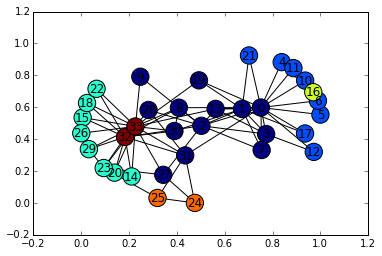

In [17]:
nx.draw_networkx_nodes(G,pos,pos,node_color=cutree.T[28])
nx.draw_networkx_edges(G,pos)
nx.draw_networkx_labels(G, pos)

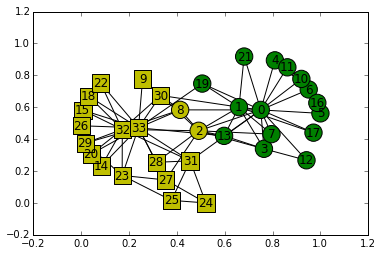

In [18]:
pos = nx.spring_layout(G, pos=pos)
nx.draw_networkx_nodes(G,pos,with_labels=True,nodelist=[i for i, val in G.node.iteritems() if val['spectral_bi']==0],node_shape='d',node_color='b')
nx.draw_networkx_nodes(G,pos,with_labels=True,nodelist=[i for i, val in G.node.iteritems() if val['spectral_bi']==1],node_shape='s',node_color='g')
nx.draw_networkx_nodes(G,pos,with_labels=True,nodelist=[i for i, val in G.node.iteritems() if val['club']=='Mr. Hi'],node_shape='o',
                       node_color=[val['spectral_bi'] for i, val in G.node.iteritems() if val['club']=='Mr. Hi'])
nx.draw_networkx_nodes(G,pos,with_labels=True,nodelist=[i for i, val in G.node.iteritems() if val['club']=='Officer'],
                       node_shape='s',
                       node_color=[val['spectral_bi'] for i, val in G.node.iteritems() if val['club']=='Officer'])
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G,pos)

In [70]:

distances=np.zeros((len(dicto),len(dicto)))
for u,p in enumerate(dicto.items()):
    for v,d in enumerate(p[1].items()):
        distances[u][v]=d[1]

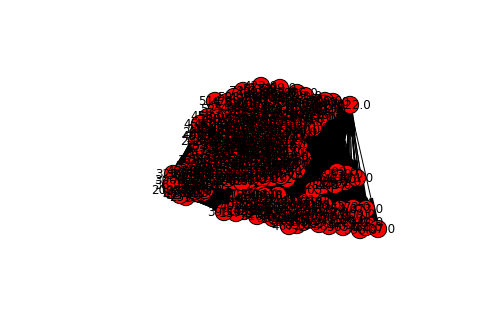

In [71]:
# now with citibike network

G=network
# pos = nx.spring_layout(G)

nx.draw(G,pos=station_positions,with_labels=True)

path_length=nx.all_pairs_shortest_path_length(G)
distances=np.zeros((len(G),len(G)))
for u,p in enumerate(path_length.items()):
    for v,d in enumerate(p[1].items()):
        distances[u][v]=d[1]
# Create hierarchical cluster
Y = distance.pdist(distances)
Z = hierarchy.complete(Y)  # Creates HC using farthest point linkage
S = hierarchy.single(Y)  # Creates HC using single linkage

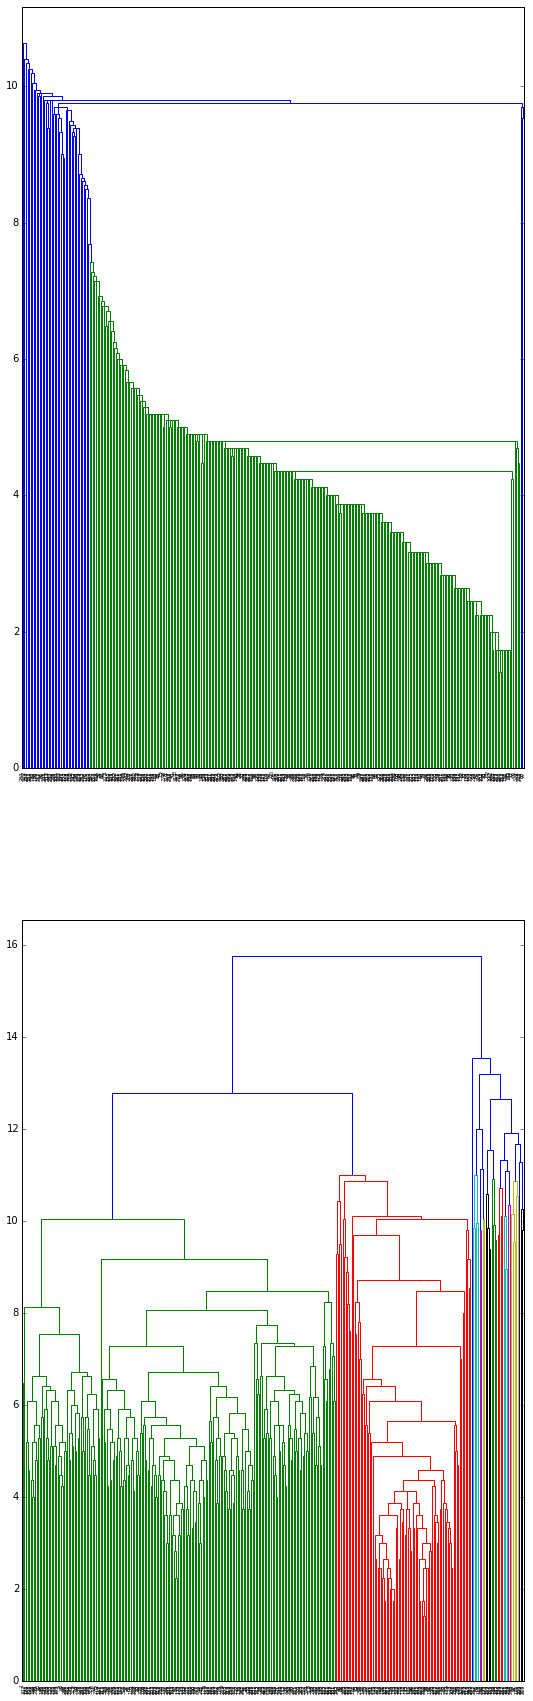

In [72]:
fig, axes = plt.subplots(2, 1, figsize=(9, 30))
dn = hierarchy.dendrogram(S, ax=axes[0],)
dn1 = hierarchy.dendrogram(Z, ax=axes[1])

In [123]:
cutreeS = hierarchy.cut_tree(S)
cutree = hierarchy.cut_tree(Z)

In [153]:
cutreeS.T[280]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  2,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,
        5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  7,  0,  0,
        8,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0, 11, 12,
        0,  0,  0,  0,  0,  0, 13,  0,  0, 14, 15,  0, 16, 17,  0,  0, 18,
        0,  0, 19,  0,  0,  0,  0,  0,  0,  0, 20,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, 21,  0,  0,  0,  0,  0,  0,  0, 22,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, 23, 24,  0,  0,  0,  0,  0,  0,  0,  0, 25, 26,  0,  0,  0,
        0,  0,  0,  0,  0,  0, 27, 28, 29,  0,  0,  0, 30, 31,  0,  0,  0,
        0,  0,  0,  0,  0, 32,  0,  0,  0,  0,  0, 33,  0,  0,  0,  0, 34,
        0, 35, 36, 37,  0

In [97]:
G2 = nx.convert_node_labels_to_integers(G)

In [98]:
hier_labels = {}
colors = ['r','b','g','y']
for i, val in enumerate(cutree[6]):
    hier_labels[i] = colors[val]
nx.set_node_attributes(G2,'cut_hierachical',hier_labels)

In [134]:
hier_labels = {}
colors = ['r','b','g','y']
for i, val in enumerate(cutreeS.T[326]):
    hier_labels[i] = colors[val]
nx.set_node_attributes(G2,'complete_linkage',hier_labels)

In [135]:
stations = (data[['start station id', 'start station latitude', 'start station longitude','start station name',]]
            .drop_duplicates('start station id')
            .rename(columns={'start station latitude':'latitude', 'start station longitude':'longitude'})
            .set_index('start station id'))
station_positions2={}
for c, val in enumerate(stations.index):
    station_positions2[c]=(stations['longitude'][val],stations['latitude'][val])

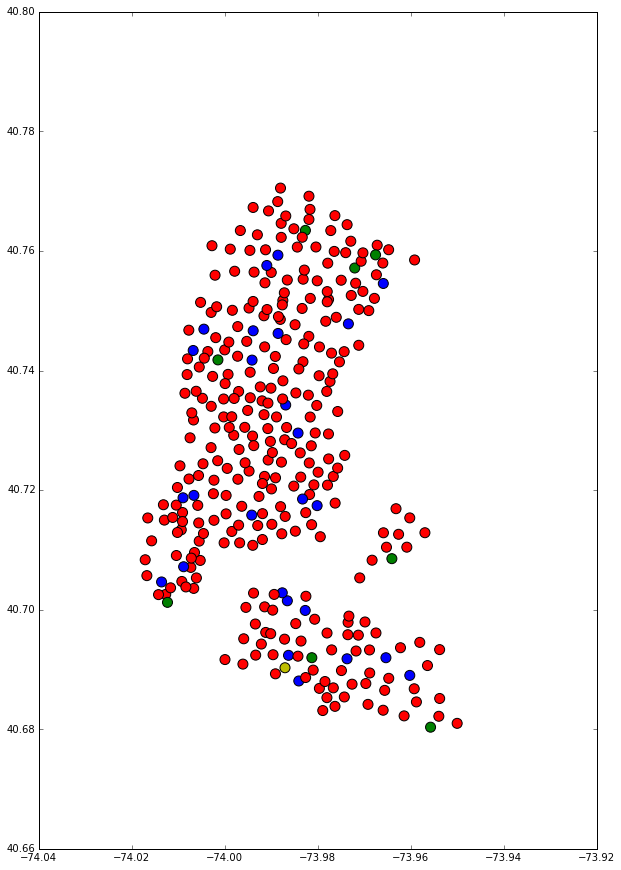

In [162]:
fig = plt.figure(figsize=(10,15))
nx.draw_networkx_nodes(G2,station_positions2,node_color=[val['cut_hierachical'] for i, val in G2.node.iteritems()],node_size=100)
# nx.draw_networkx_edges(G2,station_positions2)
# nx.draw_networkx_labels(G2,station_positions2)

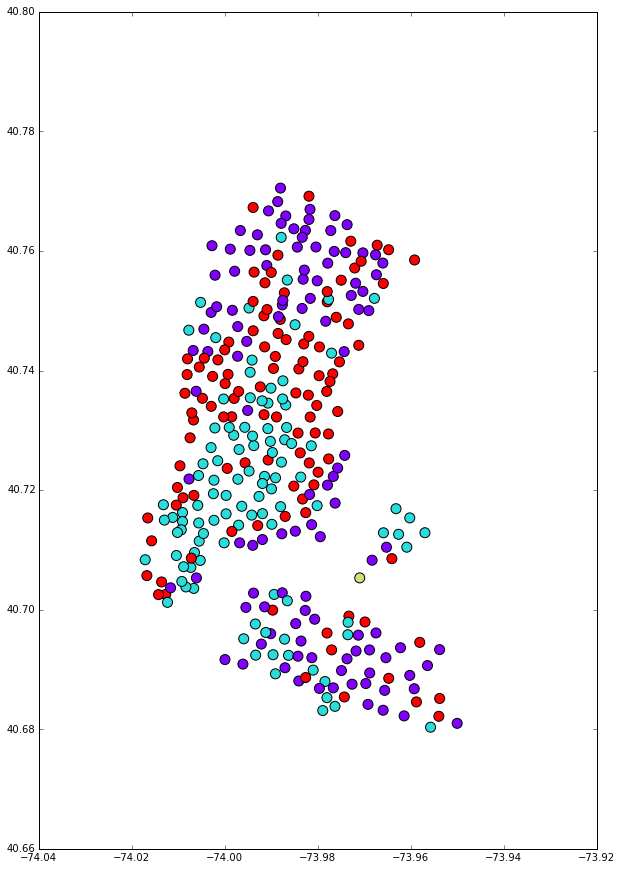

In [160]:
plt.figure(figsize=(10,15))
spectral = sklearn.cluster.SpectralClustering(n_clusters=4)
labels = spectral.fit_predict(laplacian_matrix)
nx.draw_networkx_nodes(network,pos=station_positions,node_color=labels,cmap='rainbow',with_labels=False,node_size=100)
plt.show()

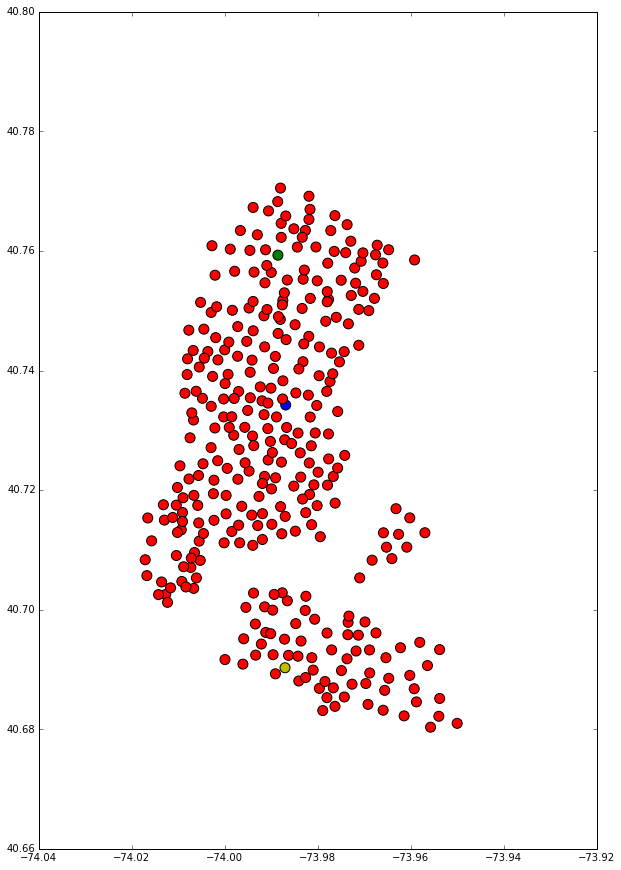

In [137]:
fig = plt.figure(figsize=(10,15))
nx.draw_networkx_nodes(G2,station_positions2,node_color=[val['complete_linkage'] for i, val in G2.node.iteritems()],node_size=100)
# nx.draw_networkx_edges(G2,station_positions2)
# nx.draw_networkx_labels(G2,station_positions2)

# Simple K-means clustering

In [163]:
from sklearn.cluster import KMeans

In [165]:
kmeans2 = KMeans(n_clusters=4)

In [176]:
latlongs = np.asarray([stations['latitude'],stations['longitude']]).T

In [177]:
kmeans2.fit(latlongs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [180]:
stacluster = stations
stacluster['cluster label']=kmeans2.labels_

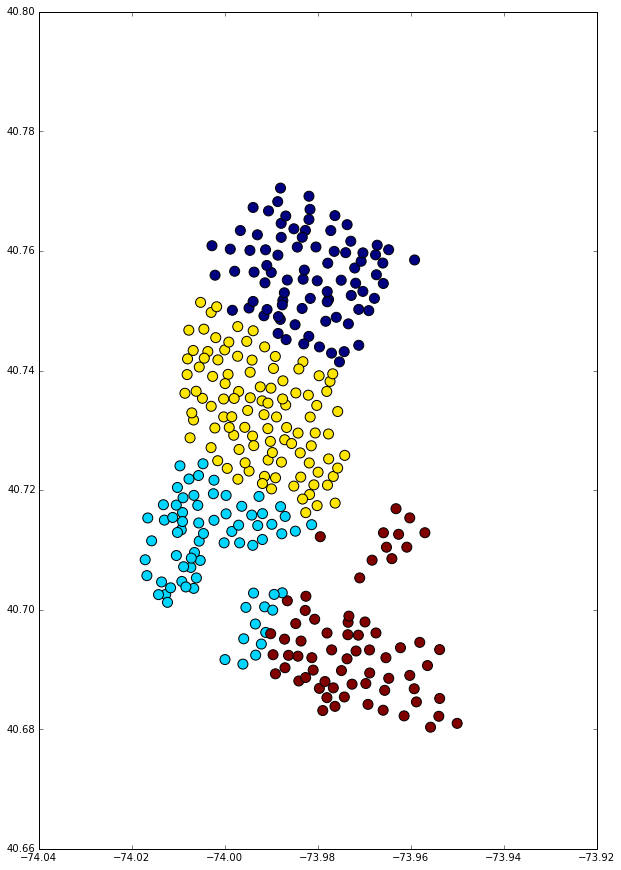

In [189]:
plt.figure(figsize=(10,15))
plt.scatter(stacluster['longitude'],stacluster['latitude'],c=stacluster['cluster label'],s=100)


# More explorations of networkx

In [526]:
degrees = network.degree(weight='weight')
in_degrees = network.in_degree(weight='weight')
out_degrees = network.out_degree(weight='weight')

In [63]:
network.subgraph([72,79]).degree()

{72: 4, 79: 4}

In [57]:
network.size()

95630

In [64]:
from networkx.algorithms import approximation

In [87]:
strong_connected = nx.is_strongly_connected(network)
weak_connected = nx.is_weakly_connected(network)
weak_components = nx.weakly_connected_components(network)

In [88]:
print strong_connected
print weak_connected

True
True


In [94]:
one_node_nonneighbors = [i for i in nx.non_neighbors(network,72)]

In [152]:
G = nx.barbell_graph(m1=5, m2=1)

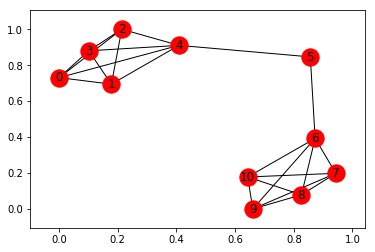

In [153]:
nx.draw_networkx(G)

In [154]:
centralityG = nx.centrality.betweenness_centrality(G)

In [155]:
centralityG

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.5333333333333333,
 5: 0.5555555555555556,
 6: 0.5333333333333333,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0}

In [156]:
list(nx.find_cliques(G))

[[4, 0, 1, 2, 3], [4, 5], [6, 8, 9, 10, 7], [6, 5]]

In [157]:
nx.triangles(G)

{0: 6, 1: 6, 2: 6, 3: 6, 4: 6, 5: 0, 6: 6, 7: 6, 8: 6, 9: 6, 10: 6}

In [158]:
flow_value, flow_dict = nx.maximum_flow(network, 72, 79, capacity='inv_weight')

In [159]:
flow_value

30.511215329257062

In [171]:
import networkx as nx
T = nx.DiGraph()
T.add_edge('x','a', capacity=3.0)
T.add_edge('x','b', capacity=1.0)
T.add_edge('a','c', capacity=3.0)
T.add_edge('b','c', capacity=5.0)
T.add_edge('b','d', capacity=4.0)
T.add_edge('d','e', capacity=2.0)
T.add_edge('c','y', capacity=2.0)
T.add_edge('e','y', capacity=3.0)

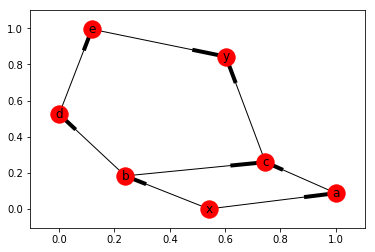

In [172]:
nx.draw_networkx(T,with_labels=True)

In [209]:
flow_value, flow_dict = nx.maximum_flow(T, 'x', 'c', capacity='capacity')

In [210]:
flow_value

4.0

In [208]:
flow_dict

{'a': {'c': 2.0},
 'b': {'c': 0, 'd': 1.0},
 'c': {'y': 2.0},
 'd': {'e': 1.0},
 'e': {'y': 1.0},
 'x': {'a': 2.0, 'b': 1.0},
 'y': {}}

In [154]:
cent = nx.centrality.betweenness_centrality(network, weight='inv_weight')

In [159]:
centralities = pd.DataFrame({'station_id': list(cent.keys()), 'cents': list(cent.values())}).set_index('station_id')